In [1]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as utils
from tqdm import tqdm
import config
import process_data

In [2]:
# define ivim function
def ivim(b, Dp, Dt, Fp):
    return Fp*np.exp(-b*Dp) + (1-Fp)*np.exp(-b*Dt)

# apply mask: only keep vox with mask = 1

**Single subject Data 100206**

In [3]:
scan = process_data.get_nifti_data(config.data_folder2 + '/100206/data.nii.gz')

In [4]:
mask = process_data.get_nifti_data(config.data_folder2 + '/100206/nodif_brain_mask.nii.gz')

In [5]:
scan_dimension = scan.shape
x = scan_dimension[0]
y = scan_dimension[1]
z = scan_dimension[2]
b = scan_dimension[3]

In [6]:
print(x, y, z, b)

print('The shape of scan: ')
print(scan.shape)
print('The shape of mask: ')
print(mask.shape)

print(type(scan), type(mask))

145 174 145 288
The shape of scan: 
(145, 174, 145, 288)
The shape of mask: 
(145, 174, 145)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>


In [7]:
scan_long = np.reshape(scan, (x*y*z, b))

In [8]:
mask_long = np.reshape(mask, (x*y*z, 1))

In [15]:
scan_long_no_background = process_data.trim_background(scan_long, mask_long)

In [16]:
scan_long_no_background.shape

(936256, 288)

In [18]:
scan_long_no_bg_cp = scan_long_no_background

In [19]:
# Ignore all strange data

def find_rows_beginning_with_zero(scan_long_no_bg):
    return np.where(scan_long_no_bg[:, 0] == 0)[0]

Sb_beginning_0 = find_rows_beginning_with_zero(scan_long_no_background)
scan_long_no_bg = np.delete(scan_long_no_background, Sb_beginning_0, 0)

print(scan_long_no_bg.shape)
print(scan_long_no_background.shape)

(935442, 288)
(936256, 288)


In [ ]:
# Ignore data that leads to S0 in [0, 1)

# bval_list = np.loadtxt(config.data_folder2 + '/100206/bvals')
# S0 = process_data.get_S0(scan_long_no_background, bval_list)
# error_voxels = np.argwhere(np.logical_and(S0 >= 0, S0 < 1))[:,0]
# scan_long_no_bg = np.delete(scan_long_no_background, error_voxels, 0)
# S0_ = np.delete(S0, error_voxels, 0)
# np.save('S0_2.npy',S0_)

In [3]:
bval_list = np.loadtxt(config.data_folder2 + '/100206/bvals')

In [21]:
S0 = process_data.get_S0(scan_long_no_bg, bval_list)
# S0 = np.load('S0_1.npy')

In [22]:
S0.shape

(935442, 1)

In [24]:
normalized_scan_long_no_background = process_data.normalize_scan(scan_long_no_bg, S0)

In [4]:
# np.save('normalized_scan_long_2.npy', normalized_scan_long_no_background)
normalized_scan_long_no_background = np.load('normalized_scan_long_1.npy')

In [32]:
# normalized_scan_long_no_background.shape
Ab_voxels = np.argwhere(np.logical_and(S0 >= 0, S0 < 1))[:,0]
print(Ab_voxels)

[229768 536137 850262]


In [33]:
scan_long_no_bg

array([[587.17718506, 358.32980347, 231.72703552, ..., 299.55273438,
        255.15158081, 142.32798767],
       [507.74441528, 209.08628845, 260.41522217, ..., 203.17358398,
        306.38717651, 163.31565857],
       [487.08456421, 222.9410553 , 164.82409668, ..., 173.70411682,
        261.70492554, 141.86515808],
       ...,
       [812.58972168, 293.08770752, 151.81272888, ..., 234.93511963,
        148.44284058, 252.454422  ],
       [611.19360352, 356.01541138, 282.81274414, ..., 197.86349487,
        240.8157196 , 113.83872986],
       [881.83642578, 131.84002686, 136.59486389, ..., 252.69070435,
        327.61587524, 269.12463379]])

In [35]:
print(normalized_scan_long_no_background.shape)
print(S0.shape)

(935439, 288)
(935442, 1)


In [36]:
np.argwhere(normalized_scan_long_no_background>10)

array([[117489,      4],
       [117489,     20],
       [117489,     60],
       ...,
       [784703,    214],
       [784703,    231],
       [838711,     90]])

In [5]:
np.unique(bval_list)

array([   5.,  990.,  995., 1000., 1005., 1985., 1990., 1995., 2000.,
       2005., 2010., 2980., 2985., 2990., 2995., 3000., 3005., 3010.])

## Neural Network Training

Let's create the neural network class and instantiate it.

In [5]:
class Net(nn.Module):
    def __init__(self, b_values_no0):
        super(Net, self).__init__()

        self.b_values_no0 = b_values_no0
        self.fc_layers = nn.ModuleList()
        for i in range(3): # 3 fully connected hidden layers
            self.fc_layers.extend([nn.Linear(len(b_values_no0), len(b_values_no0)), nn.ELU()])
        self.encoder = nn.Sequential(*self.fc_layers, nn.Linear(len(b_values_no0), 3))

    def forward(self, X):
        # print('x')
        # print(X.shape)
        params = torch.abs(self.encoder(X)) # Dp, Dt, Fp
        # print(params.shape)
        # print(params)
        Dp = params[:, 0].unsqueeze(1)
        Dt = params[:, 1].unsqueeze(1)
        Fp = params[:, 2].unsqueeze(1)

        X = Fp*torch.exp(-self.b_values_no0*Dp) + (1-Fp)*torch.exp(-self.b_values_no0*Dt)

        return X, Dp, Dt, Fp

In [6]:
net = Net(bval_list)
print(net)

Net(
  (fc_layers): ModuleList(
    (0): Linear(in_features=288, out_features=288, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=288, out_features=288, bias=True)
    (3): ELU(alpha=1.0)
    (4): Linear(in_features=288, out_features=288, bias=True)
    (5): ELU(alpha=1.0)
  )
  (encoder): Sequential(
    (0): Linear(in_features=288, out_features=288, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=288, out_features=288, bias=True)
    (3): ELU(alpha=1.0)
    (4): Linear(in_features=288, out_features=288, bias=True)
    (5): ELU(alpha=1.0)
    (6): Linear(in_features=288, out_features=3, bias=True)
  )
)


In [6]:
# Network
b_values = torch.FloatTensor(bval_list)
net = Net(b_values)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr = 0.00001)  

Create batch queues.

In [7]:
batch_size = 128
num_batches = len(normalized_scan_long_no_background) // batch_size
# X_train = X_train[:,1:] # exlude the b=0 value as signals are normalized
trainloader = utils.DataLoader(torch.from_numpy(normalized_scan_long_no_background.astype(np.float32)),
                                batch_size = batch_size, 
                                shuffle = True,
                                num_workers = 2,
                                drop_last = True)

In [14]:
net2 = Net(b_values)

Train, this might take a few minutes.

In [ ]:
# epoch, lr, layer, data size increase

In [8]:
loss_arr=[]

# Best loss
best = 1e16
num_bad_epochs = 0
patience = 400

# Train
counter = 0
for epoch in range(400): 
    print("-----------------------------------------------------------------")
    print("Epoch: {}; Bad epochs: {}".format(epoch, num_bad_epochs))
    net.train()
    running_loss = 0.

    for i, X_batch in enumerate(tqdm(trainloader), 0):
        # print('Running_loss: ', running_loss)
        # print('X_batch: ')
        # print(X_batch.shape)
        # print(X_batch)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        X_pred, Dp_pred, Dt_pred, Fp_pred = net(X_batch)
        # print('X_pred: ')
        # print(X_pred.shape)
        # print(X_pred)
        if i == 8 and counter == 10:
            print('X_batch: ')
            print(X_batch)
            print('X_pred: ')
            print(X_pred)
        loss = criterion(X_pred, X_batch)
        loss.backward()
        optimizer.step()
        # print('loss: ', loss.item())
        running_loss += loss.item()
        
    loss_arr.append(running_loss)
    print("Loss: {}".format(running_loss))
    print("Average Loss: {}".format(running_loss/len(trainloader)))
    # early stopping
    if running_loss < best:
        print("############### Saving good model ###############################")
        final_model = net.state_dict()
        best = running_loss
        num_bad_epochs = 0
    else:
        num_bad_epochs = num_bad_epochs + 1
        if num_bad_epochs == patience:
            print("Done, best loss: {}".format(best))
            break
    counter += 1
print("Done")
# Restore best model
net.load_state_dict(final_model)

-----------------------------------------------------------------
Epoch: 0; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:45<00:00, 159.60it/s]


Loss: 1225.7519965320826
Average Loss: 0.16772742152874692
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 1; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 203.99it/s]


Loss: 1202.1002131700516
Average Loss: 0.16449099797072408
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 2; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 194.91it/s]


Loss: 1179.1982013061643
Average Loss: 0.16135717040314235
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 3; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 204.80it/s]


Loss: 1203.9027749747038
Average Loss: 0.16473765393742526
-----------------------------------------------------------------
Epoch: 4; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 208.57it/s]


Loss: 1050.2482443265617
Average Loss: 0.14371212976553938
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 5; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 210.39it/s]


Loss: 726.834048261866
Average Loss: 0.09945731366473262
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 6; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 217.99it/s]


Loss: 645.6243521729484
Average Loss: 0.08834487577626551
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 7; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 226.83it/s]


Loss: 657.6735045537353
Average Loss: 0.0899936377331329
-----------------------------------------------------------------
Epoch: 8; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 211.51it/s]


Loss: 614.4095888845623
Average Loss: 0.08407356169739494
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 9; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 218.42it/s]


Loss: 661.9056010991335
Average Loss: 0.09057274235072982
-----------------------------------------------------------------
Epoch: 10; Bad epochs: 1


  1%|▋                                                                                                       | 52/7308 [00:01<02:35, 46.57it/s]

X_batch: 
tensor([[1.0411, 0.3814, 0.2106,  ..., 0.3016, 0.2317, 0.0624],
        [0.9515, 0.5091, 0.2290,  ..., 0.5521, 0.2769, 0.1937],
        [0.9701, 0.4151, 0.3020,  ..., 0.5842, 0.3312, 0.1957],
        ...,
        [1.1788, 0.1765, 0.0747,  ..., 0.1288, 0.0613, 0.0520],
        [0.9609, 0.5914, 0.4163,  ..., 0.5185, 0.3720, 0.3437],
        [0.9792, 0.3204, 0.1850,  ..., 0.3556, 0.1906, 0.1242]])
X_pred: 
tensor([[0.9037, 0.2936, 0.2548,  ..., 0.2934, 0.2548, 0.2207],
        [0.9467, 0.4183, 0.3870,  ..., 0.4182, 0.3870, 0.3577],
        [0.9639, 0.4470, 0.4032,  ..., 0.4468, 0.4032, 0.3632],
        ...,
        [0.7840, 0.1086, 0.0814,  ..., 0.1084, 0.0814, 0.0609],
        [0.9456, 0.4757, 0.4266,  ..., 0.4755, 0.4266, 0.3821],
        [0.8938, 0.2808, 0.2328,  ..., 0.2805, 0.2328, 0.1927]],
       grad_fn=<AddBackward0>)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 214.37it/s]


Loss: 638.4877797383815
Average Loss: 0.08736833329753442
-----------------------------------------------------------------
Epoch: 11; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 219.16it/s]


Loss: 669.3686775621027
Average Loss: 0.09159396244692154
-----------------------------------------------------------------
Epoch: 12; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 221.15it/s]


Loss: 658.1953018056229
Average Loss: 0.09006503856125107
-----------------------------------------------------------------
Epoch: 13; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 219.82it/s]


Loss: 671.5840623602271
Average Loss: 0.09189710760265833
-----------------------------------------------------------------
Epoch: 14; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 214.94it/s]


Loss: 593.7819649754092
Average Loss: 0.08125095306176919
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 15; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 224.70it/s]


Loss: 633.6001178696752
Average Loss: 0.08669952351801795
-----------------------------------------------------------------
Epoch: 16; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 228.88it/s]


Loss: 611.4952668137848
Average Loss: 0.08367477652076968
-----------------------------------------------------------------
Epoch: 17; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 221.32it/s]


Loss: 618.732273939997
Average Loss: 0.08466506211548946
-----------------------------------------------------------------
Epoch: 18; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 231.16it/s]


Loss: 615.6079484736547
Average Loss: 0.0842375408420436
-----------------------------------------------------------------
Epoch: 19; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 224.97it/s]


Loss: 612.3586433976889
Average Loss: 0.0837929178157757
-----------------------------------------------------------------
Epoch: 20; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 219.73it/s]


Loss: 639.5561806913465
Average Loss: 0.08751452937757889
-----------------------------------------------------------------
Epoch: 21; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 223.73it/s]


Loss: 660.517599963583
Average Loss: 0.09038281335024399
-----------------------------------------------------------------
Epoch: 22; Bad epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 228.72it/s]


Loss: 635.21837817505
Average Loss: 0.08692096034141353
-----------------------------------------------------------------
Epoch: 23; Bad epochs: 8


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 230.62it/s]


Loss: 639.0468408856541
Average Loss: 0.08744483318085032
-----------------------------------------------------------------
Epoch: 24; Bad epochs: 9


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 227.10it/s]


Loss: 694.5903990110382
Average Loss: 0.09504521059264344
-----------------------------------------------------------------
Epoch: 25; Bad epochs: 10


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 218.24it/s]


Loss: 696.6659370642155
Average Loss: 0.0953292196311187
-----------------------------------------------------------------
Epoch: 26; Bad epochs: 11


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 215.74it/s]


Loss: 585.920568831265
Average Loss: 0.0801752283567686
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 27; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 232.58it/s]


Loss: 622.7092456342652
Average Loss: 0.08520925638126235
-----------------------------------------------------------------
Epoch: 28; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 222.71it/s]


Loss: 644.1855854671448
Average Loss: 0.08814800020075873
-----------------------------------------------------------------
Epoch: 29; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 226.89it/s]


Loss: 612.3672855300829
Average Loss: 0.08379410037357456
-----------------------------------------------------------------
Epoch: 30; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 220.82it/s]


Loss: 592.4306119615212
Average Loss: 0.08106603885625632
-----------------------------------------------------------------
Epoch: 31; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 225.22it/s]


Loss: 597.5880188252777
Average Loss: 0.0817717595546357
-----------------------------------------------------------------
Epoch: 32; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 229.84it/s]


Loss: 590.0592161230743
Average Loss: 0.08074154572017984
-----------------------------------------------------------------
Epoch: 33; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 227.26it/s]


Loss: 587.4676525779068
Average Loss: 0.08038692564010767
-----------------------------------------------------------------
Epoch: 34; Bad epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 218.45it/s]


Loss: 582.2490008017048
Average Loss: 0.079672824411837
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 35; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 211.71it/s]


Loss: 627.9001020202413
Average Loss: 0.08591955418996186
-----------------------------------------------------------------
Epoch: 36; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 213.41it/s]


Loss: 603.6693528350443
Average Loss: 0.08260390706555067
-----------------------------------------------------------------
Epoch: 37; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 223.75it/s]


Loss: 645.1283044451848
Average Loss: 0.08827699841888133
-----------------------------------------------------------------
Epoch: 38; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 234.60it/s]


Loss: 674.5643125576898
Average Loss: 0.09230491414308838
-----------------------------------------------------------------
Epoch: 39; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 231.06it/s]


Loss: 692.2726116608828
Average Loss: 0.09472805304609781
-----------------------------------------------------------------
Epoch: 40; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 225.51it/s]


Loss: 729.51087110769
Average Loss: 0.09982360031577586
-----------------------------------------------------------------
Epoch: 41; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 226.35it/s]


Loss: 601.4755596639588
Average Loss: 0.08230371642911315
-----------------------------------------------------------------
Epoch: 42; Bad epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 229.01it/s]


Loss: 607.6509245960042
Average Loss: 0.08314873078763056
-----------------------------------------------------------------
Epoch: 43; Bad epochs: 8


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 229.30it/s]


Loss: 649.6209102263674
Average Loss: 0.08889175016781163
-----------------------------------------------------------------
Epoch: 44; Bad epochs: 9


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 234.87it/s]


Loss: 630.0910224476829
Average Loss: 0.08621935173066268
-----------------------------------------------------------------
Epoch: 45; Bad epochs: 10


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 231.43it/s]


Loss: 629.2989586815238
Average Loss: 0.08611096862089816
-----------------------------------------------------------------
Epoch: 46; Bad epochs: 11


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 232.72it/s]


Loss: 610.3898909576237
Average Loss: 0.08352352093016198
-----------------------------------------------------------------
Epoch: 47; Bad epochs: 12


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 235.04it/s]


Loss: 650.1428666841239
Average Loss: 0.0889631727810788
-----------------------------------------------------------------
Epoch: 48; Bad epochs: 13


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 231.44it/s]


Loss: 609.7746129371226
Average Loss: 0.0834393285354574
-----------------------------------------------------------------
Epoch: 49; Bad epochs: 14


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 224.76it/s]


Loss: 579.5957455378957
Average Loss: 0.0793097626625473
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 50; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 229.39it/s]


Loss: 640.0456030312926
Average Loss: 0.0875815001411183
-----------------------------------------------------------------
Epoch: 51; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 229.44it/s]


Loss: 754.3031302252784
Average Loss: 0.1032160824063052
-----------------------------------------------------------------
Epoch: 52; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 234.06it/s]


Loss: 628.783101147972
Average Loss: 0.08604038056211988
-----------------------------------------------------------------
Epoch: 53; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 236.81it/s]


Loss: 641.1775137735531
Average Loss: 0.08773638666852122
-----------------------------------------------------------------
Epoch: 54; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 219.86it/s]


Loss: 655.784223751165
Average Loss: 0.08973511545582444
-----------------------------------------------------------------
Epoch: 55; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 195.12it/s]


Loss: 611.0607345812023
Average Loss: 0.08361531671882899
-----------------------------------------------------------------
Epoch: 56; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 208.92it/s]


Loss: 600.252136121504
Average Loss: 0.08213630762472687
-----------------------------------------------------------------
Epoch: 57; Bad epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 221.24it/s]


Loss: 574.8295278251171
Average Loss: 0.07865757085729572
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 58; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 223.78it/s]


Loss: 579.304541788064
Average Loss: 0.07926991540613902
-----------------------------------------------------------------
Epoch: 59; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 222.92it/s]


Loss: 578.5743702710606
Average Loss: 0.07917000140545438
-----------------------------------------------------------------
Epoch: 60; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 226.34it/s]


Loss: 611.4391319230199
Average Loss: 0.08366709522756156
-----------------------------------------------------------------
Epoch: 61; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 220.31it/s]


Loss: 554.2607649299316
Average Loss: 0.07584301654760969
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 62; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 206.93it/s]


Loss: 656.5808379817754
Average Loss: 0.08984412123450676
-----------------------------------------------------------------
Epoch: 63; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 217.99it/s]


Loss: 571.1884757140651
Average Loss: 0.07815934259907843
-----------------------------------------------------------------
Epoch: 64; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 222.67it/s]


Loss: 631.0691601401195
Average Loss: 0.08635319651616304
-----------------------------------------------------------------
Epoch: 65; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 220.17it/s]


Loss: 574.321990259923
Average Loss: 0.07858812127256747
-----------------------------------------------------------------
Epoch: 66; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 224.21it/s]


Loss: 568.3488346464001
Average Loss: 0.07777077649786536
-----------------------------------------------------------------
Epoch: 67; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 228.60it/s]


Loss: 563.3980446774513
Average Loss: 0.07709332849992491
-----------------------------------------------------------------
Epoch: 68; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 228.54it/s]


Loss: 590.4662875151262
Average Loss: 0.08079724788110648
-----------------------------------------------------------------
Epoch: 69; Bad epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 228.52it/s]


Loss: 598.627520292066
Average Loss: 0.081914001134656
-----------------------------------------------------------------
Epoch: 70; Bad epochs: 8


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 213.74it/s]


Loss: 575.0510839470662
Average Loss: 0.07868788778695487
-----------------------------------------------------------------
Epoch: 71; Bad epochs: 9


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 225.85it/s]


Loss: 580.7135168518871
Average Loss: 0.0794627144022834
-----------------------------------------------------------------
Epoch: 72; Bad epochs: 10


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 232.06it/s]


Loss: 576.767357096076
Average Loss: 0.07892273632951231
-----------------------------------------------------------------
Epoch: 73; Bad epochs: 11


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 229.09it/s]


Loss: 545.1794397514313
Average Loss: 0.07460036121393424
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 74; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 227.27it/s]


Loss: 602.6309624803253
Average Loss: 0.08246181752604341
-----------------------------------------------------------------
Epoch: 75; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 227.45it/s]


Loss: 593.3376102074981
Average Loss: 0.08119014918000794
-----------------------------------------------------------------
Epoch: 76; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 229.49it/s]


Loss: 571.59946501581
Average Loss: 0.07821558087244253
-----------------------------------------------------------------
Epoch: 77; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 227.73it/s]


Loss: 599.9856937942095
Average Loss: 0.08209984863084421
-----------------------------------------------------------------
Epoch: 78; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 224.58it/s]


Loss: 597.187343054451
Average Loss: 0.08171693254713343
-----------------------------------------------------------------
Epoch: 79; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 218.59it/s]


Loss: 601.0736037762836
Average Loss: 0.08224871425510175
-----------------------------------------------------------------
Epoch: 80; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 221.07it/s]


Loss: 590.4347435762174
Average Loss: 0.08079293152383928
-----------------------------------------------------------------
Epoch: 81; Bad epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 226.01it/s]


Loss: 628.5185285238549
Average Loss: 0.08600417741158387
-----------------------------------------------------------------
Epoch: 82; Bad epochs: 8


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 224.83it/s]


Loss: 562.5195991070941
Average Loss: 0.07697312521990889
-----------------------------------------------------------------
Epoch: 83; Bad epochs: 9


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 233.45it/s]


Loss: 575.3296631723642
Average Loss: 0.0787260075495846
-----------------------------------------------------------------
Epoch: 84; Bad epochs: 10


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 240.31it/s]


Loss: 565.7814768357202
Average Loss: 0.07741946864199785
-----------------------------------------------------------------
Epoch: 85; Bad epochs: 11


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 236.83it/s]


Loss: 653.7152937827632
Average Loss: 0.08945201064350893
-----------------------------------------------------------------
Epoch: 86; Bad epochs: 12


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 237.60it/s]


Loss: 558.0325754252262
Average Loss: 0.07635913730503917
-----------------------------------------------------------------
Epoch: 87; Bad epochs: 13


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 236.16it/s]


Loss: 577.3096868880093
Average Loss: 0.07899694675533789
-----------------------------------------------------------------
Epoch: 88; Bad epochs: 14


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 236.84it/s]


Loss: 590.3114036973566
Average Loss: 0.0807760541457795
-----------------------------------------------------------------
Epoch: 89; Bad epochs: 15


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 233.42it/s]


Loss: 543.825304699596
Average Loss: 0.07441506632452052
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 90; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 229.03it/s]


Loss: 566.6819503745064
Average Loss: 0.07754268614867356
-----------------------------------------------------------------
Epoch: 91; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 235.22it/s]


Loss: 568.245173891075
Average Loss: 0.07775659193911809
-----------------------------------------------------------------
Epoch: 92; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 224.89it/s]


Loss: 567.2606168547645
Average Loss: 0.07762186875407287
-----------------------------------------------------------------
Epoch: 93; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 235.55it/s]


Loss: 579.2524977903813
Average Loss: 0.07926279389578289
-----------------------------------------------------------------
Epoch: 94; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 233.50it/s]


Loss: 561.1469690338708
Average Loss: 0.0767852995393912
-----------------------------------------------------------------
Epoch: 95; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 235.90it/s]


Loss: 589.1073307860643
Average Loss: 0.08061129321101043
-----------------------------------------------------------------
Epoch: 96; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 236.54it/s]


Loss: 633.1047046780586
Average Loss: 0.08663173298824009
-----------------------------------------------------------------
Epoch: 97; Bad epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 233.01it/s]


Loss: 608.7910589147359
Average Loss: 0.08330474259917021
-----------------------------------------------------------------
Epoch: 98; Bad epochs: 8


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 227.23it/s]


Loss: 591.8365114405751
Average Loss: 0.08098474431316026
-----------------------------------------------------------------
Epoch: 99; Bad epochs: 9


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 228.28it/s]


Loss: 552.4127023858018
Average Loss: 0.07559013442608126
-----------------------------------------------------------------
Epoch: 100; Bad epochs: 10


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 239.19it/s]


Loss: 576.9180037816986
Average Loss: 0.0789433502711684
-----------------------------------------------------------------
Epoch: 101; Bad epochs: 11


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 234.07it/s]


Loss: 551.5389492013492
Average Loss: 0.07547057323499579
-----------------------------------------------------------------
Epoch: 102; Bad epochs: 12


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 230.95it/s]


Loss: 568.7052488317713
Average Loss: 0.0778195469118461
-----------------------------------------------------------------
Epoch: 103; Bad epochs: 13


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 228.55it/s]


Loss: 590.2222862057388
Average Loss: 0.08076385963406388
-----------------------------------------------------------------
Epoch: 104; Bad epochs: 14


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 234.09it/s]


Loss: 548.0727326590568
Average Loss: 0.07499626883676201
-----------------------------------------------------------------
Epoch: 105; Bad epochs: 15


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 232.49it/s]


Loss: 562.1907417089678
Average Loss: 0.07692812557593977
-----------------------------------------------------------------
Epoch: 106; Bad epochs: 16


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 234.95it/s]


Loss: 567.6262146835215
Average Loss: 0.07767189582423667
-----------------------------------------------------------------
Epoch: 107; Bad epochs: 17


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 233.75it/s]


Loss: 587.5389245254919
Average Loss: 0.08039667823282592
-----------------------------------------------------------------
Epoch: 108; Bad epochs: 18


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 235.58it/s]


Loss: 597.449412247166
Average Loss: 0.08175279313726957
-----------------------------------------------------------------
Epoch: 109; Bad epochs: 19


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 236.92it/s]


Loss: 580.4437363119796
Average Loss: 0.07942579861959218
-----------------------------------------------------------------
Epoch: 110; Bad epochs: 20


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 236.22it/s]


Loss: 556.6750242589042
Average Loss: 0.07617337496700932
-----------------------------------------------------------------
Epoch: 111; Bad epochs: 21


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 230.77it/s]


Loss: 568.7637371397577
Average Loss: 0.07782755023806208
-----------------------------------------------------------------
Epoch: 112; Bad epochs: 22


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 232.70it/s]


Loss: 536.2791203823872
Average Loss: 0.07338247405341916
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 113; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 225.34it/s]


Loss: 557.9632562473416
Average Loss: 0.07634965192218687
-----------------------------------------------------------------
Epoch: 114; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 234.10it/s]


Loss: 541.7273402623832
Average Loss: 0.07412798854165069
-----------------------------------------------------------------
Epoch: 115; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 231.32it/s]


Loss: 530.0437141805887
Average Loss: 0.07252924386707563
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 116; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 226.66it/s]


Loss: 568.6903974916786
Average Loss: 0.07781751470876828
-----------------------------------------------------------------
Epoch: 117; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 234.96it/s]


Loss: 574.6429146220908
Average Loss: 0.0786320353889013
-----------------------------------------------------------------
Epoch: 118; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 222.93it/s]


Loss: 543.6520570293069
Average Loss: 0.07439135974675792
-----------------------------------------------------------------
Epoch: 119; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 232.17it/s]


Loss: 568.65553082712
Average Loss: 0.07781274368187191
-----------------------------------------------------------------
Epoch: 120; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 234.32it/s]


Loss: 570.1955569316633
Average Loss: 0.07802347522327084
-----------------------------------------------------------------
Epoch: 121; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 235.14it/s]


Loss: 545.5587200848386
Average Loss: 0.07465226054800747
-----------------------------------------------------------------
Epoch: 122; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 237.73it/s]


Loss: 523.4982171347365
Average Loss: 0.07163358198340675
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 123; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 231.10it/s]


Loss: 550.8661662996747
Average Loss: 0.07537851208260464
-----------------------------------------------------------------
Epoch: 124; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 239.69it/s]


Loss: 555.3497420959175
Average Loss: 0.07599202820141181
-----------------------------------------------------------------
Epoch: 125; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 234.82it/s]


Loss: 553.6924252994359
Average Loss: 0.07576524703057415
-----------------------------------------------------------------
Epoch: 126; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 231.55it/s]


Loss: 557.8023030399345
Average Loss: 0.07632762767377319
-----------------------------------------------------------------
Epoch: 127; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 236.75it/s]


Loss: 582.5761846960522
Average Loss: 0.07971759505966779
-----------------------------------------------------------------
Epoch: 128; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 239.27it/s]


Loss: 506.8942400831729
Average Loss: 0.06936155447224589
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 129; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 238.31it/s]


Loss: 535.9746852386743
Average Loss: 0.07334081626144968
-----------------------------------------------------------------
Epoch: 130; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 240.10it/s]


Loss: 515.0720073580742
Average Loss: 0.0704805702460419
-----------------------------------------------------------------
Epoch: 131; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 235.84it/s]


Loss: 560.226106446702
Average Loss: 0.0766592920698826
-----------------------------------------------------------------
Epoch: 132; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 235.74it/s]


Loss: 556.8280857168138
Average Loss: 0.0761943193372761
-----------------------------------------------------------------
Epoch: 133; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 232.16it/s]


Loss: 555.5063250144012
Average Loss: 0.07601345443546814
-----------------------------------------------------------------
Epoch: 134; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 237.65it/s]


Loss: 573.892712732777
Average Loss: 0.0785293805053061
-----------------------------------------------------------------
Epoch: 135; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 229.46it/s]


Loss: 524.3404083084315
Average Loss: 0.07174882434433928
-----------------------------------------------------------------
Epoch: 136; Bad epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 234.40it/s]


Loss: 526.769772357773
Average Loss: 0.07208124963844732
-----------------------------------------------------------------
Epoch: 137; Bad epochs: 8


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 237.00it/s]


Loss: 528.0978720905259
Average Loss: 0.07226298194998987
-----------------------------------------------------------------
Epoch: 138; Bad epochs: 9


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 225.02it/s]


Loss: 548.8944096677005
Average Loss: 0.0751087041143542
-----------------------------------------------------------------
Epoch: 139; Bad epochs: 10


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 225.75it/s]


Loss: 485.5706184329465
Average Loss: 0.06644370805048529
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 140; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 231.68it/s]


Loss: 544.0818519964814
Average Loss: 0.07445017131862089
-----------------------------------------------------------------
Epoch: 141; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 232.60it/s]


Loss: 627.7872789483517
Average Loss: 0.08590411589331579
-----------------------------------------------------------------
Epoch: 142; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 239.09it/s]


Loss: 560.5724511840381
Average Loss: 0.07670668461741079
-----------------------------------------------------------------
Epoch: 143; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 234.65it/s]


Loss: 518.0134435668588
Average Loss: 0.07088306562217553
-----------------------------------------------------------------
Epoch: 144; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 234.31it/s]


Loss: 574.6920217070729
Average Loss: 0.07863875502286163
-----------------------------------------------------------------
Epoch: 145; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 239.84it/s]


Loss: 543.9908702233806
Average Loss: 0.07443772170544344
-----------------------------------------------------------------
Epoch: 146; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 225.51it/s]


Loss: 503.4490281729959
Average Loss: 0.06889012427107223
-----------------------------------------------------------------
Epoch: 147; Bad epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 232.46it/s]


Loss: 522.2841723472811
Average Loss: 0.07146745653356337
-----------------------------------------------------------------
Epoch: 148; Bad epochs: 8


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 233.81it/s]


Loss: 527.9344843081199
Average Loss: 0.0722406245632348
-----------------------------------------------------------------
Epoch: 149; Bad epochs: 9


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 236.95it/s]


Loss: 541.8628377150744
Average Loss: 0.07414652951766207
-----------------------------------------------------------------
Epoch: 150; Bad epochs: 10


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 230.36it/s]


Loss: 486.2758724587038
Average Loss: 0.06654021243277283
-----------------------------------------------------------------
Epoch: 151; Bad epochs: 11


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 222.41it/s]


Loss: 517.4033395312726
Average Loss: 0.07079958121664924
-----------------------------------------------------------------
Epoch: 152; Bad epochs: 12


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 225.14it/s]


Loss: 523.2598694157787
Average Loss: 0.07160096735300749
-----------------------------------------------------------------
Epoch: 153; Bad epochs: 13


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 230.60it/s]


Loss: 503.165067830123
Average Loss: 0.06885126817598837
-----------------------------------------------------------------
Epoch: 154; Bad epochs: 14


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 219.60it/s]


Loss: 508.14892183756456
Average Loss: 0.06953324053606522
-----------------------------------------------------------------
Epoch: 155; Bad epochs: 15


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 235.53it/s]


Loss: 528.8064273991622
Average Loss: 0.07235993806775619
-----------------------------------------------------------------
Epoch: 156; Bad epochs: 16


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 221.80it/s]


Loss: 535.7115185400471
Average Loss: 0.07330480549261728
-----------------------------------------------------------------
Epoch: 157; Bad epochs: 17


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 233.43it/s]


Loss: 648.2929604891688
Average Loss: 0.08871003838111231
-----------------------------------------------------------------
Epoch: 158; Bad epochs: 18


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 234.79it/s]


Loss: 512.6547795189545
Average Loss: 0.07014980562656739
-----------------------------------------------------------------
Epoch: 159; Bad epochs: 19


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 231.25it/s]


Loss: 548.0809192182496
Average Loss: 0.07499738905558971
-----------------------------------------------------------------
Epoch: 160; Bad epochs: 20


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 226.80it/s]


Loss: 524.5462524946779
Average Loss: 0.07177699131016392
-----------------------------------------------------------------
Epoch: 161; Bad epochs: 21


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 230.53it/s]


Loss: 527.1257695774548
Average Loss: 0.07212996299636765
-----------------------------------------------------------------
Epoch: 162; Bad epochs: 22


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 232.24it/s]


Loss: 554.5394886620343
Average Loss: 0.07588115608402221
-----------------------------------------------------------------
Epoch: 163; Bad epochs: 23


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 216.11it/s]


Loss: 588.264807171654
Average Loss: 0.0804960053601059
-----------------------------------------------------------------
Epoch: 164; Bad epochs: 24


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 232.70it/s]


Loss: 593.3862710460089
Average Loss: 0.08119680775123275
-----------------------------------------------------------------
Epoch: 165; Bad epochs: 25


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 232.55it/s]


Loss: 511.6391323050484
Average Loss: 0.07001082817529398
-----------------------------------------------------------------
Epoch: 166; Bad epochs: 26


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 231.54it/s]


Loss: 549.1838882341981
Average Loss: 0.07514831530298277
-----------------------------------------------------------------
Epoch: 167; Bad epochs: 27


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 229.84it/s]


Loss: 502.64297722186893
Average Loss: 0.0687798272060576
-----------------------------------------------------------------
Epoch: 168; Bad epochs: 28


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 232.70it/s]


Loss: 520.5952658397146
Average Loss: 0.07123635274216127
-----------------------------------------------------------------
Epoch: 169; Bad epochs: 29


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 232.49it/s]


Loss: 511.2472244608216
Average Loss: 0.06995720093880975
-----------------------------------------------------------------
Epoch: 170; Bad epochs: 30


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 232.71it/s]


Loss: 526.902993418742
Average Loss: 0.07209947912133853
-----------------------------------------------------------------
Epoch: 171; Bad epochs: 31


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 232.03it/s]


Loss: 519.0612979801372
Average Loss: 0.07102645018885292
-----------------------------------------------------------------
Epoch: 172; Bad epochs: 32


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 232.74it/s]


Loss: 551.9679358252324
Average Loss: 0.07552927419611828
-----------------------------------------------------------------
Epoch: 173; Bad epochs: 33


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 220.27it/s]


Loss: 542.2316651516594
Average Loss: 0.07419699851555274
-----------------------------------------------------------------
Epoch: 174; Bad epochs: 34


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 238.34it/s]


Loss: 503.1518369796686
Average Loss: 0.0688494577147877
-----------------------------------------------------------------
Epoch: 175; Bad epochs: 35


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 233.36it/s]


Loss: 492.9124996829778
Average Loss: 0.06744834423686068
-----------------------------------------------------------------
Epoch: 176; Bad epochs: 36


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 224.35it/s]


Loss: 501.9496260480955
Average Loss: 0.06868495156651554
-----------------------------------------------------------------
Epoch: 177; Bad epochs: 37


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 223.38it/s]


Loss: 522.4546201196499
Average Loss: 0.07149077998353173
-----------------------------------------------------------------
Epoch: 178; Bad epochs: 38


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 227.41it/s]


Loss: 521.2989412811585
Average Loss: 0.07133264111674309
-----------------------------------------------------------------
Epoch: 179; Bad epochs: 39


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 234.46it/s]


Loss: 499.46833652444184
Average Loss: 0.06834542098035602
-----------------------------------------------------------------
Epoch: 180; Bad epochs: 40


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 227.20it/s]


Loss: 540.1119030741975
Average Loss: 0.0739069380232892
-----------------------------------------------------------------
Epoch: 181; Bad epochs: 41


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 229.81it/s]


Loss: 492.1718735122122
Average Loss: 0.06734699965958021
-----------------------------------------------------------------
Epoch: 182; Bad epochs: 42


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 234.93it/s]


Loss: 518.6835735714994
Average Loss: 0.07097476376183627
-----------------------------------------------------------------
Epoch: 183; Bad epochs: 43


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 235.95it/s]


Loss: 511.6905679292977
Average Loss: 0.07001786643805387
-----------------------------------------------------------------
Epoch: 184; Bad epochs: 44


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 228.46it/s]


Loss: 483.018592717126
Average Loss: 0.0660944981824201
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 185; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 228.11it/s]


Loss: 526.9398587546311
Average Loss: 0.07210452363911209
-----------------------------------------------------------------
Epoch: 186; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 231.53it/s]


Loss: 522.5925303054973
Average Loss: 0.07150965110912662
-----------------------------------------------------------------
Epoch: 187; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 233.03it/s]


Loss: 535.0509954192676
Average Loss: 0.07321442192381877
-----------------------------------------------------------------
Epoch: 188; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 232.51it/s]


Loss: 530.9354578498751
Average Loss: 0.07265126681032774
-----------------------------------------------------------------
Epoch: 189; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 235.81it/s]


Loss: 533.3030760101974
Average Loss: 0.07297524302274185
-----------------------------------------------------------------
Epoch: 190; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 237.59it/s]


Loss: 526.3469607476145
Average Loss: 0.07202339364362541
-----------------------------------------------------------------
Epoch: 191; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 231.82it/s]


Loss: 492.1992166787386
Average Loss: 0.06735074119851377
-----------------------------------------------------------------
Epoch: 192; Bad epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 227.46it/s]


Loss: 510.4760372340679
Average Loss: 0.06985167449836725
-----------------------------------------------------------------
Epoch: 193; Bad epochs: 8


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 236.99it/s]


Loss: 498.8991290819831
Average Loss: 0.06826753271510443
-----------------------------------------------------------------
Epoch: 194; Bad epochs: 9


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 233.58it/s]


Loss: 502.4010644662194
Average Loss: 0.06874672474907216
-----------------------------------------------------------------
Epoch: 195; Bad epochs: 10


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 228.97it/s]


Loss: 534.3722477126867
Average Loss: 0.07312154456933315
-----------------------------------------------------------------
Epoch: 196; Bad epochs: 11


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 235.76it/s]


Loss: 505.89363720919937
Average Loss: 0.06922463563344272
-----------------------------------------------------------------
Epoch: 197; Bad epochs: 12


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 219.48it/s]


Loss: 482.86578391538933
Average Loss: 0.06607358838470023
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 198; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 225.22it/s]


Loss: 519.1173660261557
Average Loss: 0.07103412233527034
-----------------------------------------------------------------
Epoch: 199; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 236.21it/s]


Loss: 503.9425727096386
Average Loss: 0.06895765910093578
-----------------------------------------------------------------
Epoch: 200; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 230.19it/s]


Loss: 516.7546477830037
Average Loss: 0.07071081660960643
-----------------------------------------------------------------
Epoch: 201; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 234.63it/s]


Loss: 495.8911861171946
Average Loss: 0.06785593679764568
-----------------------------------------------------------------
Epoch: 202; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 238.47it/s]


Loss: 515.6102550220676
Average Loss: 0.07055422208840552
-----------------------------------------------------------------
Epoch: 203; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 220.01it/s]


Loss: 513.8449599579908
Average Loss: 0.07031266556622753
-----------------------------------------------------------------
Epoch: 204; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 233.52it/s]


Loss: 512.0634388048202
Average Loss: 0.07006888872534485
-----------------------------------------------------------------
Epoch: 205; Bad epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 233.91it/s]


Loss: 509.11115848319605
Average Loss: 0.06966490948045923
-----------------------------------------------------------------
Epoch: 206; Bad epochs: 8


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 220.93it/s]


Loss: 503.02393333939835
Average Loss: 0.068831955848303
-----------------------------------------------------------------
Epoch: 207; Bad epochs: 9


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 226.88it/s]


Loss: 497.8252031216398
Average Loss: 0.0681205806132512
-----------------------------------------------------------------
Epoch: 208; Bad epochs: 10


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 227.93it/s]


Loss: 477.1115267658606
Average Loss: 0.06528619687545985
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 209; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 222.03it/s]


Loss: 493.5606384393759
Average Loss: 0.06753703317451777
-----------------------------------------------------------------
Epoch: 210; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 221.57it/s]


Loss: 484.883392051328
Average Loss: 0.06634967050510783
-----------------------------------------------------------------
Epoch: 211; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 224.73it/s]


Loss: 510.45216293260455
Average Loss: 0.06984840762624583
-----------------------------------------------------------------
Epoch: 212; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 231.87it/s]


Loss: 512.8973543834873
Average Loss: 0.07018299868411156
-----------------------------------------------------------------
Epoch: 213; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 223.03it/s]


Loss: 506.1168305478059
Average Loss: 0.06925517659384317
-----------------------------------------------------------------
Epoch: 214; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 236.78it/s]


Loss: 498.7015958959237
Average Loss: 0.06824050299615814
-----------------------------------------------------------------
Epoch: 215; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 227.06it/s]


Loss: 542.8581777778454
Average Loss: 0.07428272821262252
-----------------------------------------------------------------
Epoch: 216; Bad epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 231.91it/s]


Loss: 522.3016629233025
Average Loss: 0.07146984988003592
-----------------------------------------------------------------
Epoch: 217; Bad epochs: 8


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 234.10it/s]


Loss: 497.83720064675435
Average Loss: 0.06812222231072172
-----------------------------------------------------------------
Epoch: 218; Bad epochs: 9


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 225.48it/s]


Loss: 492.8231681743637
Average Loss: 0.06743612043984178
-----------------------------------------------------------------
Epoch: 219; Bad epochs: 10


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 233.76it/s]


Loss: 498.3222004631534
Average Loss: 0.0681885879123089
-----------------------------------------------------------------
Epoch: 220; Bad epochs: 11


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 232.37it/s]


Loss: 504.7981909462251
Average Loss: 0.06907473877206145
-----------------------------------------------------------------
Epoch: 221; Bad epochs: 12


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 231.60it/s]


Loss: 488.45670310175046
Average Loss: 0.06683862932426798
-----------------------------------------------------------------
Epoch: 222; Bad epochs: 13


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 231.48it/s]


Loss: 560.2227244074456
Average Loss: 0.0766588292839964
-----------------------------------------------------------------
Epoch: 223; Bad epochs: 14


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 231.35it/s]


Loss: 522.0664149117656
Average Loss: 0.07143765940226678
-----------------------------------------------------------------
Epoch: 224; Bad epochs: 15


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 235.12it/s]


Loss: 492.3278908012435
Average Loss: 0.06736834849497038
-----------------------------------------------------------------
Epoch: 225; Bad epochs: 16


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 231.42it/s]


Loss: 510.29399791313335
Average Loss: 0.06982676490327495
-----------------------------------------------------------------
Epoch: 226; Bad epochs: 17


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 231.52it/s]


Loss: 512.3046077308245
Average Loss: 0.07010188939940128
-----------------------------------------------------------------
Epoch: 227; Bad epochs: 18


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 232.62it/s]


Loss: 508.3545551300049
Average Loss: 0.0695613786439525
-----------------------------------------------------------------
Epoch: 228; Bad epochs: 19


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 232.89it/s]


Loss: 504.0333765395917
Average Loss: 0.0689700843650235
-----------------------------------------------------------------
Epoch: 229; Bad epochs: 20


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 233.47it/s]


Loss: 523.7878508893773
Average Loss: 0.07167321440741342
-----------------------------------------------------------------
Epoch: 230; Bad epochs: 21


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 230.76it/s]


Loss: 491.43354232190177
Average Loss: 0.06724596911903417
-----------------------------------------------------------------
Epoch: 231; Bad epochs: 22


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 232.96it/s]


Loss: 481.9915149589069
Average Loss: 0.065953956617256
-----------------------------------------------------------------
Epoch: 232; Bad epochs: 23


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 232.21it/s]


Loss: 476.74996081599966
Average Loss: 0.06523672151286257
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 233; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 234.70it/s]


Loss: 521.1944976914674
Average Loss: 0.07131834943780342
-----------------------------------------------------------------
Epoch: 234; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 230.77it/s]


Loss: 541.1288793389685
Average Loss: 0.07404609733702361
-----------------------------------------------------------------
Epoch: 235; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 234.08it/s]


Loss: 533.4159782682545
Average Loss: 0.07299069215493358
-----------------------------------------------------------------
Epoch: 236; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 233.46it/s]


Loss: 494.0504441857338
Average Loss: 0.06760405640198876
-----------------------------------------------------------------
Epoch: 237; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 233.71it/s]


Loss: 522.1034241067246
Average Loss: 0.07144272360518945
-----------------------------------------------------------------
Epoch: 238; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 230.80it/s]


Loss: 485.2176998988725
Average Loss: 0.06639541596864704
-----------------------------------------------------------------
Epoch: 239; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 230.35it/s]


Loss: 489.3774509183131
Average Loss: 0.06696462108898647
-----------------------------------------------------------------
Epoch: 240; Bad epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 234.27it/s]


Loss: 490.3521168422885
Average Loss: 0.06709799081038431
-----------------------------------------------------------------
Epoch: 241; Bad epochs: 8


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 231.51it/s]


Loss: 492.9771294547245
Average Loss: 0.06745718793852278
-----------------------------------------------------------------
Epoch: 242; Bad epochs: 9


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 228.45it/s]


Loss: 492.9986389288679
Average Loss: 0.06746013121632018
-----------------------------------------------------------------
Epoch: 243; Bad epochs: 10


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 234.75it/s]


Loss: 524.568116561044
Average Loss: 0.07177998310906458
-----------------------------------------------------------------
Epoch: 244; Bad epochs: 11


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 234.05it/s]


Loss: 490.2101445617154
Average Loss: 0.06707856384259926
-----------------------------------------------------------------
Epoch: 245; Bad epochs: 12


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 230.33it/s]


Loss: 521.6231511901133
Average Loss: 0.07137700481528643
-----------------------------------------------------------------
Epoch: 246; Bad epochs: 13


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 231.04it/s]


Loss: 498.5169503111392
Average Loss: 0.06821523676944981
-----------------------------------------------------------------
Epoch: 247; Bad epochs: 14


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 235.45it/s]


Loss: 488.2598798936233
Average Loss: 0.06681169675610608
-----------------------------------------------------------------
Epoch: 248; Bad epochs: 15


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 234.56it/s]


Loss: 493.2582633793354
Average Loss: 0.06749565727686582
-----------------------------------------------------------------
Epoch: 249; Bad epochs: 16


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 231.72it/s]


Loss: 500.0432669892907
Average Loss: 0.0684240923630666
-----------------------------------------------------------------
Epoch: 250; Bad epochs: 17


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 235.46it/s]


Loss: 486.8180491486564
Average Loss: 0.06661440190868315
-----------------------------------------------------------------
Epoch: 251; Bad epochs: 18


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 235.00it/s]


Loss: 475.64688868867233
Average Loss: 0.06508578115608543
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 252; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 233.87it/s]


Loss: 479.9277112451382
Average Loss: 0.06567155326288153
-----------------------------------------------------------------
Epoch: 253; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 228.12it/s]


Loss: 486.7926658624783
Average Loss: 0.06661092855261061
-----------------------------------------------------------------
Epoch: 254; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 237.43it/s]


Loss: 473.5022400529124
Average Loss: 0.0647923152781763
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 255; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 234.97it/s]


Loss: 504.1829188307747
Average Loss: 0.06899054718538242
-----------------------------------------------------------------
Epoch: 256; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 225.00it/s]


Loss: 478.0952757806517
Average Loss: 0.06542080949379471
-----------------------------------------------------------------
Epoch: 257; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 227.20it/s]


Loss: 498.08150824392214
Average Loss: 0.06815565246906433
-----------------------------------------------------------------
Epoch: 258; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 233.09it/s]


Loss: 482.5556010059081
Average Loss: 0.0660311440894784
-----------------------------------------------------------------
Epoch: 259; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 236.43it/s]


Loss: 464.35849891090766
Average Loss: 0.06354111917226432
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 260; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 230.60it/s]


Loss: 483.7529628123157
Average Loss: 0.06619498670119262
-----------------------------------------------------------------
Epoch: 261; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 231.62it/s]


Loss: 489.4274886120111
Average Loss: 0.06697146806404092
-----------------------------------------------------------------
Epoch: 262; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 231.97it/s]


Loss: 496.51131248800084
Average Loss: 0.06794079262287915
-----------------------------------------------------------------
Epoch: 263; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 237.47it/s]


Loss: 475.4814873836003
Average Loss: 0.06506314824625073
-----------------------------------------------------------------
Epoch: 264; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 228.66it/s]


Loss: 482.3755489848554
Average Loss: 0.06600650642923582
-----------------------------------------------------------------
Epoch: 265; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 234.67it/s]


Loss: 497.2513087708503
Average Loss: 0.06804205100860021
-----------------------------------------------------------------
Epoch: 266; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 229.69it/s]


Loss: 488.0294332676567
Average Loss: 0.06678016328238325
-----------------------------------------------------------------
Epoch: 267; Bad epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 222.39it/s]


Loss: 487.73884247476235
Average Loss: 0.06674039990076114
-----------------------------------------------------------------
Epoch: 268; Bad epochs: 8


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 224.11it/s]


Loss: 518.4208599925041
Average Loss: 0.07093881499623757
-----------------------------------------------------------------
Epoch: 269; Bad epochs: 9


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 225.25it/s]


Loss: 471.7731728553772
Average Loss: 0.0645557160447971
-----------------------------------------------------------------
Epoch: 270; Bad epochs: 10


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 233.74it/s]


Loss: 473.1595402993262
Average Loss: 0.0647454214968974
-----------------------------------------------------------------
Epoch: 271; Bad epochs: 11


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 230.89it/s]


Loss: 480.7359263668768
Average Loss: 0.06578214646508987
-----------------------------------------------------------------
Epoch: 272; Bad epochs: 12


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 233.22it/s]


Loss: 482.1808326463215
Average Loss: 0.06597986215740578
-----------------------------------------------------------------
Epoch: 273; Bad epochs: 13


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 232.69it/s]


Loss: 497.26897327182814
Average Loss: 0.06804446815432788
-----------------------------------------------------------------
Epoch: 274; Bad epochs: 14


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 232.97it/s]


Loss: 480.7119884043932
Average Loss: 0.0657788708818272
-----------------------------------------------------------------
Epoch: 275; Bad epochs: 15


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 228.72it/s]


Loss: 469.22962541040033
Average Loss: 0.06420766631231532
-----------------------------------------------------------------
Epoch: 276; Bad epochs: 16


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 230.84it/s]


Loss: 476.76176944701
Average Loss: 0.06523833736275451
-----------------------------------------------------------------
Epoch: 277; Bad epochs: 17


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 236.53it/s]


Loss: 481.9467677869834
Average Loss: 0.0659478335778576
-----------------------------------------------------------------
Epoch: 278; Bad epochs: 18


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 229.63it/s]


Loss: 507.27509920764714
Average Loss: 0.06941366984231624
-----------------------------------------------------------------
Epoch: 279; Bad epochs: 19


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 231.28it/s]


Loss: 492.3623080230318
Average Loss: 0.06737305802176133
-----------------------------------------------------------------
Epoch: 280; Bad epochs: 20


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 231.18it/s]


Loss: 494.8636915385723
Average Loss: 0.06771533819630163
-----------------------------------------------------------------
Epoch: 281; Bad epochs: 21


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 232.67it/s]


Loss: 495.3102559298277
Average Loss: 0.06777644443484232
-----------------------------------------------------------------
Epoch: 282; Bad epochs: 22


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 229.21it/s]


Loss: 483.76732406858355
Average Loss: 0.06619695184299172
-----------------------------------------------------------------
Epoch: 283; Bad epochs: 23


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 225.93it/s]


Loss: 473.7041822820902
Average Loss: 0.06481994831446226
-----------------------------------------------------------------
Epoch: 284; Bad epochs: 24


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 230.95it/s]


Loss: 473.69348264532164
Average Loss: 0.06481848421528758
-----------------------------------------------------------------
Epoch: 285; Bad epochs: 25


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 231.32it/s]


Loss: 471.04648864548653
Average Loss: 0.06445627923446723
-----------------------------------------------------------------
Epoch: 286; Bad epochs: 26


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 235.42it/s]


Loss: 462.0724863577634
Average Loss: 0.06322830957276455
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 287; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 230.25it/s]


Loss: 471.03043730556965
Average Loss: 0.06445408282780099
-----------------------------------------------------------------
Epoch: 288; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 230.31it/s]


Loss: 480.9663528148085
Average Loss: 0.06581367717772421
-----------------------------------------------------------------
Epoch: 289; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 231.39it/s]


Loss: 469.84613264678046
Average Loss: 0.06429202690842645
-----------------------------------------------------------------
Epoch: 290; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 229.10it/s]


Loss: 470.79395032068714
Average Loss: 0.06442172281344925
-----------------------------------------------------------------
Epoch: 291; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 232.61it/s]


Loss: 456.81011616345495
Average Loss: 0.06250822607600642
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 292; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 231.61it/s]


Loss: 472.9442881094292
Average Loss: 0.06471596717425139
-----------------------------------------------------------------
Epoch: 293; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 231.31it/s]


Loss: 456.7433503009379
Average Loss: 0.06249909007949342
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 294; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 234.26it/s]


Loss: 469.9978250260465
Average Loss: 0.06431278393897735
-----------------------------------------------------------------
Epoch: 295; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 231.31it/s]


Loss: 482.574721659068
Average Loss: 0.06603376048974659
-----------------------------------------------------------------
Epoch: 296; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 236.39it/s]


Loss: 477.05087355012074
Average Loss: 0.06527789731118237
-----------------------------------------------------------------
Epoch: 297; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 228.23it/s]


Loss: 464.9191451300867
Average Loss: 0.06361783595102445
-----------------------------------------------------------------
Epoch: 298; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 234.17it/s]


Loss: 463.4916411265731
Average Loss: 0.06342250152251958
-----------------------------------------------------------------
Epoch: 299; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 231.54it/s]


Loss: 489.629936191719
Average Loss: 0.06699917025064574
-----------------------------------------------------------------
Epoch: 300; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 231.56it/s]


Loss: 491.8544235373847
Average Loss: 0.06730356096570672
-----------------------------------------------------------------
Epoch: 301; Bad epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 233.50it/s]


Loss: 472.33391814446077
Average Loss: 0.06463244637992074
-----------------------------------------------------------------
Epoch: 302; Bad epochs: 8


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 231.24it/s]


Loss: 486.537343562115
Average Loss: 0.06657599118255542
-----------------------------------------------------------------
Epoch: 303; Bad epochs: 9


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 233.21it/s]


Loss: 468.30472959345207
Average Loss: 0.06408110695039027
-----------------------------------------------------------------
Epoch: 304; Bad epochs: 10


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 233.46it/s]


Loss: 470.8022941998206
Average Loss: 0.06442286455936243
-----------------------------------------------------------------
Epoch: 305; Bad epochs: 11


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 233.80it/s]


Loss: 488.0103617995046
Average Loss: 0.06677755361241168
-----------------------------------------------------------------
Epoch: 306; Bad epochs: 12


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 227.77it/s]


Loss: 461.55139995366335
Average Loss: 0.06315700601445859
-----------------------------------------------------------------
Epoch: 307; Bad epochs: 13


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 231.39it/s]


Loss: 468.4612336596474
Average Loss: 0.06410252239458777
-----------------------------------------------------------------
Epoch: 308; Bad epochs: 14


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 232.66it/s]


Loss: 476.24738754704595
Average Loss: 0.06516795122428105
-----------------------------------------------------------------
Epoch: 309; Bad epochs: 15


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 231.24it/s]


Loss: 479.98638879088685
Average Loss: 0.065679582483701
-----------------------------------------------------------------
Epoch: 310; Bad epochs: 16


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 227.92it/s]


Loss: 488.6409785980359
Average Loss: 0.06686384490941925
-----------------------------------------------------------------
Epoch: 311; Bad epochs: 17


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 233.77it/s]


Loss: 467.36897206958383
Average Loss: 0.06395306131220359
-----------------------------------------------------------------
Epoch: 312; Bad epochs: 18


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 235.38it/s]


Loss: 492.1680275653489
Average Loss: 0.06734647339427324
-----------------------------------------------------------------
Epoch: 313; Bad epochs: 19


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 236.53it/s]


Loss: 469.2566394880414
Average Loss: 0.06421136281992904
-----------------------------------------------------------------
Epoch: 314; Bad epochs: 20


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 228.57it/s]


Loss: 454.90994463767856
Average Loss: 0.06224821355195383
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 315; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 234.17it/s]


Loss: 478.1737022497691
Average Loss: 0.06543154108508062
-----------------------------------------------------------------
Epoch: 316; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 237.06it/s]


Loss: 512.349574840162
Average Loss: 0.07010804253423125
-----------------------------------------------------------------
Epoch: 317; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 234.75it/s]


Loss: 469.78961932612583
Average Loss: 0.06428429383225587
-----------------------------------------------------------------
Epoch: 318; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 226.42it/s]


Loss: 478.1291446639225
Average Loss: 0.06542544398794779
-----------------------------------------------------------------
Epoch: 319; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 236.40it/s]


Loss: 472.5088955145329
Average Loss: 0.0646563896434774
-----------------------------------------------------------------
Epoch: 320; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 233.08it/s]


Loss: 520.5850799940526
Average Loss: 0.07123495894828306
-----------------------------------------------------------------
Epoch: 321; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 233.30it/s]


Loss: 469.2846229588613
Average Loss: 0.06421519197576099
-----------------------------------------------------------------
Epoch: 322; Bad epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 231.52it/s]


Loss: 494.6670815516263
Average Loss: 0.06768843480454657
-----------------------------------------------------------------
Epoch: 323; Bad epochs: 8


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 232.00it/s]


Loss: 462.6152883772738
Average Loss: 0.06330258461648519
-----------------------------------------------------------------
Epoch: 324; Bad epochs: 9


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 238.17it/s]


Loss: 455.27234301762655
Average Loss: 0.06229780282124064
-----------------------------------------------------------------
Epoch: 325; Bad epochs: 10


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 228.25it/s]


Loss: 477.4952077846974
Average Loss: 0.06533869838323719
-----------------------------------------------------------------
Epoch: 326; Bad epochs: 11


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 237.25it/s]


Loss: 466.7739948676899
Average Loss: 0.063871646807292
-----------------------------------------------------------------
Epoch: 327; Bad epochs: 12


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 236.89it/s]


Loss: 484.4850680786185
Average Loss: 0.0662951653090611
-----------------------------------------------------------------
Epoch: 328; Bad epochs: 13


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 236.07it/s]


Loss: 472.6931561632082
Average Loss: 0.06468160319693599
-----------------------------------------------------------------
Epoch: 329; Bad epochs: 14


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 227.33it/s]


Loss: 464.5729399812408
Average Loss: 0.06357046250427488
-----------------------------------------------------------------
Epoch: 330; Bad epochs: 15


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 239.39it/s]


Loss: 479.9539250698872
Average Loss: 0.06567514026681544
-----------------------------------------------------------------
Epoch: 331; Bad epochs: 16


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 234.13it/s]


Loss: 476.9726631101221
Average Loss: 0.06526719528053121
-----------------------------------------------------------------
Epoch: 332; Bad epochs: 17


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 234.87it/s]


Loss: 466.72940801875666
Average Loss: 0.0638655457059054
-----------------------------------------------------------------
Epoch: 333; Bad epochs: 18


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 230.28it/s]


Loss: 478.46612259792164
Average Loss: 0.0654715548163549
-----------------------------------------------------------------
Epoch: 334; Bad epochs: 19


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 236.20it/s]


Loss: 472.1153435995802
Average Loss: 0.0646025374383662
-----------------------------------------------------------------
Epoch: 335; Bad epochs: 20


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 233.24it/s]


Loss: 474.1384738716297
Average Loss: 0.06487937518768878
-----------------------------------------------------------------
Epoch: 336; Bad epochs: 21


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 233.96it/s]


Loss: 463.65995814837515
Average Loss: 0.06344553340837099
-----------------------------------------------------------------
Epoch: 337; Bad epochs: 22


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 228.29it/s]


Loss: 463.1090148659423
Average Loss: 0.06337014434399867
-----------------------------------------------------------------
Epoch: 338; Bad epochs: 23


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 237.42it/s]


Loss: 465.1077005281113
Average Loss: 0.06364363718228123
-----------------------------------------------------------------
Epoch: 339; Bad epochs: 24


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 232.49it/s]


Loss: 451.468052376993
Average Loss: 0.06177723759947906
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 340; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 228.97it/s]


Loss: 452.59644552879035
Average Loss: 0.06193164279266425
-----------------------------------------------------------------
Epoch: 341; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 234.32it/s]


Loss: 471.4803589354269
Average Loss: 0.064515648458597
-----------------------------------------------------------------
Epoch: 342; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 229.97it/s]


Loss: 464.94129201350734
Average Loss: 0.0636208664495768
-----------------------------------------------------------------
Epoch: 343; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 234.18it/s]


Loss: 453.42226822441444
Average Loss: 0.06204464535090509
-----------------------------------------------------------------
Epoch: 344; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 234.26it/s]


Loss: 459.9172989567742
Average Loss: 0.06293340160875399
-----------------------------------------------------------------
Epoch: 345; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 233.23it/s]


Loss: 454.6717896577902
Average Loss: 0.06221562529526412
-----------------------------------------------------------------
Epoch: 346; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 233.06it/s]


Loss: 455.1616626405157
Average Loss: 0.06228265772311381
-----------------------------------------------------------------
Epoch: 347; Bad epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 235.09it/s]


Loss: 458.5716908639297
Average Loss: 0.06274927351723175
-----------------------------------------------------------------
Epoch: 348; Bad epochs: 8


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 232.68it/s]


Loss: 458.6947589465417
Average Loss: 0.06276611370368661
-----------------------------------------------------------------
Epoch: 349; Bad epochs: 9


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 230.20it/s]


Loss: 451.2343091960065
Average Loss: 0.06174525303722037
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 350; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 237.47it/s]


Loss: 470.4006830379367
Average Loss: 0.06436790955636791
-----------------------------------------------------------------
Epoch: 351; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 229.38it/s]


Loss: 457.18283179122955
Average Loss: 0.06255922711976321
-----------------------------------------------------------------
Epoch: 352; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 232.72it/s]


Loss: 464.8539451775141
Average Loss: 0.06360891422790287
-----------------------------------------------------------------
Epoch: 353; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 234.80it/s]


Loss: 472.46580287395045
Average Loss: 0.06465049300409831
-----------------------------------------------------------------
Epoch: 354; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 232.43it/s]


Loss: 454.36083606025204
Average Loss: 0.06217307554190641
-----------------------------------------------------------------
Epoch: 355; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 235.03it/s]


Loss: 462.00274168048054
Average Loss: 0.06321876596613034
-----------------------------------------------------------------
Epoch: 356; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 232.99it/s]


Loss: 474.4117768574506
Average Loss: 0.06491677296899981
-----------------------------------------------------------------
Epoch: 357; Bad epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 230.07it/s]


Loss: 464.5601406614296
Average Loss: 0.06356871109214965
-----------------------------------------------------------------
Epoch: 358; Bad epochs: 8


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 234.81it/s]


Loss: 455.6652977466583
Average Loss: 0.06235157330961389
-----------------------------------------------------------------
Epoch: 359; Bad epochs: 9


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 233.43it/s]


Loss: 468.69682559743524
Average Loss: 0.0641347599339676
-----------------------------------------------------------------
Epoch: 360; Bad epochs: 10


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 233.15it/s]


Loss: 469.47390472283587
Average Loss: 0.06424109260027858
-----------------------------------------------------------------
Epoch: 361; Bad epochs: 11


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 232.29it/s]


Loss: 470.20194130856544
Average Loss: 0.0643407144647736
-----------------------------------------------------------------
Epoch: 362; Bad epochs: 12


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 233.22it/s]


Loss: 460.98479097522795
Average Loss: 0.06307947331352326
-----------------------------------------------------------------
Epoch: 363; Bad epochs: 13


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 231.39it/s]


Loss: 470.77318596234545
Average Loss: 0.06441888149457381
-----------------------------------------------------------------
Epoch: 364; Bad epochs: 14


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 224.30it/s]


Loss: 461.638708749786
Average Loss: 0.06316895303089573
-----------------------------------------------------------------
Epoch: 365; Bad epochs: 15


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 236.63it/s]


Loss: 466.18540629325435
Average Loss: 0.06379110649880328
-----------------------------------------------------------------
Epoch: 366; Bad epochs: 16


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 234.89it/s]


Loss: 456.884134021122
Average Loss: 0.06251835440902052
-----------------------------------------------------------------
Epoch: 367; Bad epochs: 17


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 229.22it/s]


Loss: 456.85424600401893
Average Loss: 0.06251426464203871
-----------------------------------------------------------------
Epoch: 368; Bad epochs: 18


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 234.85it/s]


Loss: 456.4687867863104
Average Loss: 0.06246151981202933
-----------------------------------------------------------------
Epoch: 369; Bad epochs: 19


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 233.50it/s]


Loss: 450.17586651584134
Average Loss: 0.06160041961081573
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 370; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 236.84it/s]


Loss: 449.47458965331316
Average Loss: 0.061504459449002895
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 371; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 229.80it/s]


Loss: 451.49268073029816
Average Loss: 0.06178060765329751
-----------------------------------------------------------------
Epoch: 372; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 234.98it/s]


Loss: 446.9189949114807
Average Loss: 0.06115476120846753
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 373; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 233.61it/s]


Loss: 454.1052644937299
Average Loss: 0.06213810406318143
-----------------------------------------------------------------
Epoch: 374; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 237.81it/s]


Loss: 448.10029276274145
Average Loss: 0.061316405687293574
-----------------------------------------------------------------
Epoch: 375; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 229.70it/s]


Loss: 450.32218440342695
Average Loss: 0.061620441215575666
-----------------------------------------------------------------
Epoch: 376; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 231.27it/s]


Loss: 449.1563389291987
Average Loss: 0.06146091118352472
-----------------------------------------------------------------
Epoch: 377; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 228.22it/s]


Loss: 451.6763026169501
Average Loss: 0.061805733800896295
-----------------------------------------------------------------
Epoch: 378; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 233.93it/s]


Loss: 446.9030892220326
Average Loss: 0.06115258473207889
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 379; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 227.08it/s]


Loss: 447.75272867642343
Average Loss: 0.061268846288508955
-----------------------------------------------------------------
Epoch: 380; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 225.02it/s]


Loss: 449.35078212060034
Average Loss: 0.061487518078899885
-----------------------------------------------------------------
Epoch: 381; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 233.03it/s]


Loss: 455.92634381121024
Average Loss: 0.06238729389863304
-----------------------------------------------------------------
Epoch: 382; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 232.88it/s]


Loss: 453.91944721667096
Average Loss: 0.062112677506386285
-----------------------------------------------------------------
Epoch: 383; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 221.50it/s]


Loss: 446.3186253285967
Average Loss: 0.06107260882985724
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 384; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 222.89it/s]


Loss: 447.3421894996427
Average Loss: 0.06121266960859917
-----------------------------------------------------------------
Epoch: 385; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 232.94it/s]


Loss: 448.04797498043627
Average Loss: 0.06130924671325072
-----------------------------------------------------------------
Epoch: 386; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 232.17it/s]


Loss: 447.9278722796589
Average Loss: 0.0612928122988039
-----------------------------------------------------------------
Epoch: 387; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 231.78it/s]


Loss: 445.61499159084633
Average Loss: 0.060976326161856366
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 388; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 236.60it/s]


Loss: 444.4316681907512
Average Loss: 0.06081440451433377
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 389; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 229.85it/s]


Loss: 449.13789028674364
Average Loss: 0.06145838673874434
-----------------------------------------------------------------
Epoch: 390; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 232.69it/s]


Loss: 445.8950582896359
Average Loss: 0.06101464946492008
-----------------------------------------------------------------
Epoch: 391; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 233.80it/s]


Loss: 452.14023571042344
Average Loss: 0.06186921670914387
-----------------------------------------------------------------
Epoch: 392; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 231.89it/s]


Loss: 447.2354218265973
Average Loss: 0.06119805991059076
-----------------------------------------------------------------
Epoch: 393; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 230.60it/s]


Loss: 454.67008898593485
Average Loss: 0.06221539258154555
-----------------------------------------------------------------
Epoch: 394; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 233.28it/s]


Loss: 447.2248835740611
Average Loss: 0.061196617894644374
-----------------------------------------------------------------
Epoch: 395; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 231.39it/s]


Loss: 447.24577312078327
Average Loss: 0.06119947634384008
-----------------------------------------------------------------
Epoch: 396; Bad epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 235.57it/s]


Loss: 449.81054215086624
Average Loss: 0.06155042996043599
-----------------------------------------------------------------
Epoch: 397; Bad epochs: 8


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 230.67it/s]


Loss: 443.16145971463993
Average Loss: 0.060640593830684174
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 398; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 231.77it/s]


Loss: 445.74090685136616
Average Loss: 0.06099355594572608
-----------------------------------------------------------------
Epoch: 399; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 227.68it/s]

Loss: 447.9680167604238
Average Loss: 0.06129830552277282
Done


<All keys matched successfully>

In [9]:
len(loss_arr)

400

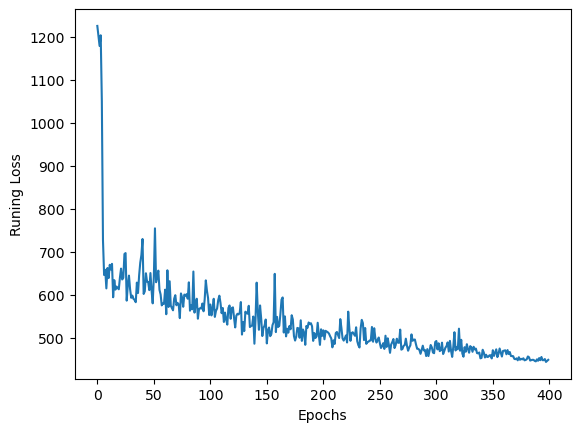

In [10]:
epoch_arr = np.arange(0, 400)
loss_arr = np.array(loss_arr)
plt.plot(epoch_arr, loss_arr)
plt.xlabel("Epochs")
plt.ylabel("Runing Loss")
plt.show()

In [13]:
torch.save(final_model, 'model_400_epoch.pt')

In [ ]:
final_model

In [55]:
saved_net = Net(b_values)
saved_net.load_state_dict(torch.load('model_200epoch.pt'))


<All keys matched successfully>

In [ ]:
saved_net.state_dict()

## Simulated Diffusion-Weighted MR Image

Create a simulated diffusion-weighted image. The image contains three regions with different Dp, Dt, and Fp values. 

In [11]:
b_arr1 = np.arange(281)
b_values_simulation = np.append(np.array([5,990,995,1000,5,990,995,1000]), b_arr1)

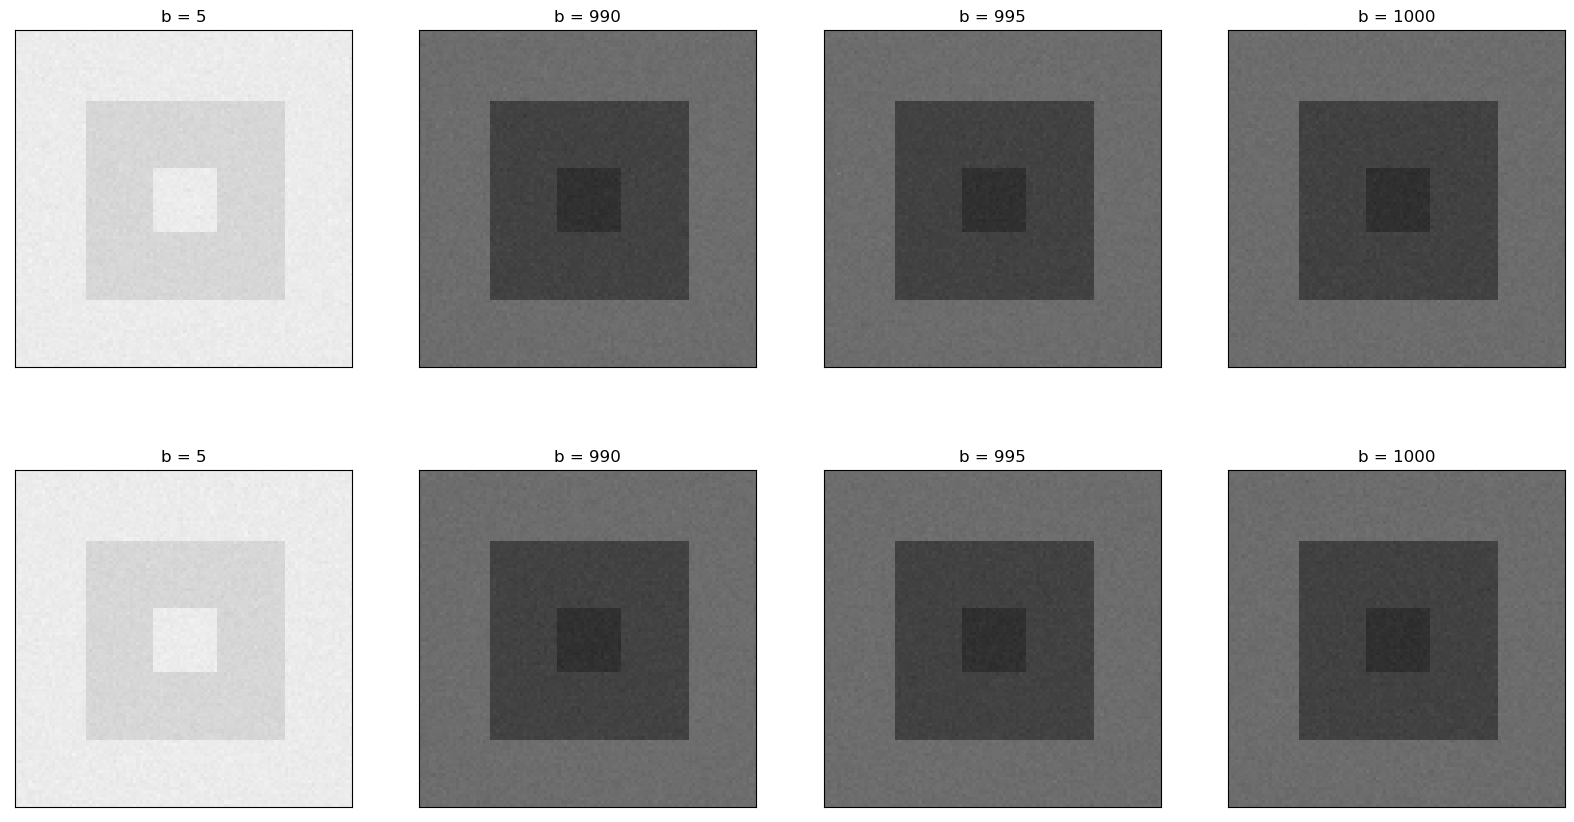

In [12]:
# define parameter values in the three regions
S0_region0, S0_region1, S0_region2 = 1500, 1400, 1600
Dp_region0, Dp_region1, Dp_region2 = 0.02, 0.04, 0.06
Dt_region0, Dt_region1, Dt_region2 = 0.0015, 0.0010, 0.0005
Fp_region0, Fp_region1, Fp_region2 = 0.1, 0.2, 0.3
# image size
sx, sy, sb = 100, 100, len(b_values_simulation)
# create image
dwi_image = np.zeros((sx, sy, sb))
Dp_truth = np.zeros((sx, sy))
Dt_truth = np.zeros((sx, sy))
Fp_truth = np.zeros((sx, sy))
# fill image with simulated values
for i in range(sx):
    for j in range(sy):
        if (40 < i < 60) and (40 < j < 60):
            # region 0
            dwi_image[i, j, :] = S0_region0*ivim(b_values_simulation, Dp_region0, Dt_region0, Fp_region0)
            Dp_truth[i, j], Dt_truth[i, j], Fp_truth[i, j] = Dp_region0, Dt_region0, Fp_region0
        elif (20 < i < 80) and (20 < j < 80):
            # region 1
            dwi_image[i, j, :] = S0_region1*ivim(b_values_simulation, Dp_region1, Dt_region1, Fp_region1)
            Dp_truth[i, j], Dt_truth[i, j], Fp_truth[i, j] = Dp_region1, Dt_region1, Fp_region1
        else:
            # region 2
            dwi_image[i, j, :] = S0_region2*ivim(b_values_simulation, Dp_region2, Dt_region2, Fp_region2)
            Dp_truth[i, j], Dt_truth[i, j], Fp_truth[i, j] = Dp_region2, Dt_region2, Fp_region2
# add some noise
dwi_image_real = dwi_image + np.random.normal(scale=15, size=(sx, sy, sb))
dwi_image_imag = np.random.normal(scale=15, size=(sx, sy, sb))
dwi_image = np.sqrt(dwi_image_real**2 + dwi_image_imag**2)
# plot simulated diffusion weighted image
fig, ax = plt.subplots(2, 4, figsize=(20,20))
b_id = 0
for i in range(2):
    for j in range(4):
        ax[i, j].imshow(dwi_image[:, :, b_id], cmap='gray', clim=(0, 1600))
        ax[i, j].set_title('b = ' + str(b_values_simulation[b_id]))
        ax[i, j].set_xticks([])
        ax[i, j].set_yticks([])
        b_id += 1
plt.subplots_adjust(hspace=-0.6)
plt.show()


## Inference

Estimate IVIM parameter values for the simulated image.

In [19]:
# b_values = torch.FloatTensor(bval_list)
net_test = Net(b_values)
net_test.load_state_dict(torch.load('model_400_epoch.pt'))
net_test.eval()

Net(
  (fc_layers): ModuleList(
    (0): Linear(in_features=288, out_features=288, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=288, out_features=288, bias=True)
    (3): ELU(alpha=1.0)
    (4): Linear(in_features=288, out_features=288, bias=True)
    (5): ELU(alpha=1.0)
  )
  (encoder): Sequential(
    (0): Linear(in_features=288, out_features=288, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=288, out_features=288, bias=True)
    (3): ELU(alpha=1.0)
    (4): Linear(in_features=288, out_features=288, bias=True)
    (5): ELU(alpha=1.0)
    (6): Linear(in_features=288, out_features=3, bias=True)
  )
)

In [20]:
dwi_img_pred_train, Dp_train, Dt_train, Fp_train = net_test(torch.from_numpy(normalized_scan_long_no_background[0:100,:].astype(np.float32)))

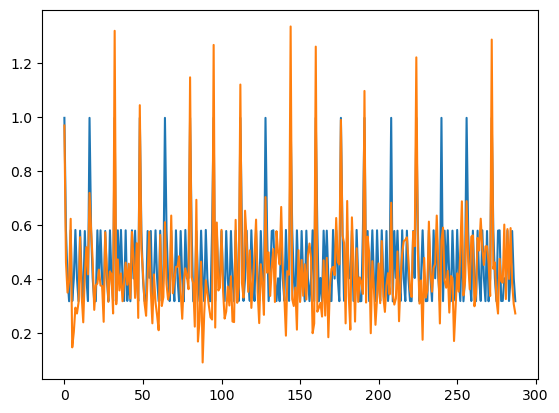

In [21]:
plt.plot(dwi_img_pred_train[0,:].detach().numpy())
plt.plot(normalized_scan_long_no_background[3,:])

In [82]:
dwi_img_pred_train[3,:]

tensor([0.9813, 0.4993, 0.3913, 0.3055, 0.4999, 0.3062, 0.3903, 0.5005, 0.3918,
        0.3059, 0.4993, 0.3922, 0.3062, 0.4987, 0.3913, 0.3062, 0.9813, 0.4999,
        0.3908, 0.3051, 0.3055, 0.4999, 0.3903, 0.4999, 0.3918, 0.3070, 0.4987,
        0.3908, 0.3055, 0.4999, 0.3913, 0.3066, 0.9813, 0.3055, 0.4999, 0.3908,
        0.5005, 0.3918, 0.3066, 0.4999, 0.3070, 0.3913, 0.3055, 0.4999, 0.3903,
        0.4993, 0.3918, 0.3062, 0.9813, 0.4987, 0.3903, 0.3062, 0.3059, 0.4987,
        0.3922, 0.4987, 0.3070, 0.3903, 0.4999, 0.3918, 0.3055, 0.4993, 0.3066,
        0.3908, 0.9813, 0.5005, 0.3903, 0.3062, 0.4993, 0.3903, 0.3059, 0.4999,
        0.3903, 0.3055, 0.4987, 0.3908, 0.3051, 0.5005, 0.3903, 0.3913, 0.9813,
        0.4993, 0.3051, 0.3070, 0.4987, 0.3913, 0.3059, 0.4993, 0.3903, 0.3059,
        0.5005, 0.3903, 0.3066, 0.3059, 0.4993, 0.9813, 0.3066, 0.4999, 0.3913,
        0.3913, 0.4987, 0.3908, 0.3062, 0.4987, 0.3898, 0.3062, 0.4987, 0.3908,
        0.3051, 0.4993, 0.3903, 0.3066, 

In [54]:
# dwi_img_pred_train, Dp_train, Dt_train, Fp_train = net(torch.from_numpy(normalized_scan_long_no_background[]))
torch.from_numpy(normalized_scan_long_no_background[1000,:].astype(np.float32)).shape

torch.Size([288])

In [57]:
torch.from_numpy(normalized_scan_long_no_background[1000,:].astype(np.float32)).shape

torch.Size([288])

In [14]:
net.eval()
dwi_img_pred_train, Dp_train, Dt_train, Fp_train = net(torch.from_numpy(normalized_scan_long_no_background[0:100,:].astype(np.float32)))

In [15]:
dwi_img_pred_train.shape

torch.Size([100, 288])

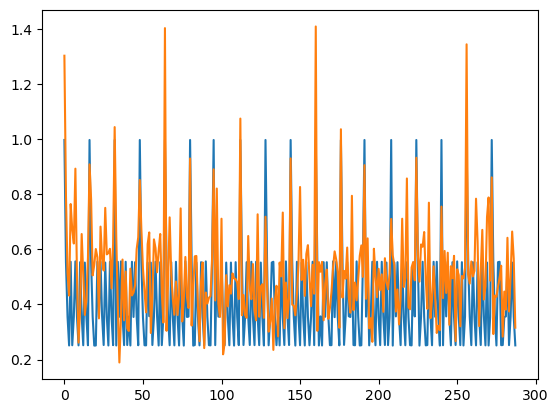

In [18]:
plt.plot(dwi_img_pred_train[0,:].detach().numpy())
plt.plot(normalized_scan_long_no_background[0,:])

In [55]:
# net.load_state_dict(final_model)
# normalize signal
dwi_image_long = np.reshape(dwi_image, (sx*sy, sb))
S0 = np.expand_dims(dwi_image_long[:,0], axis=-1)
dwi_image_long = dwi_image_long[:,1:]/S0

net.eval()
with torch.no_grad():
    dwi_img_pred, Dp, Dt, Fp = net(torch.from_numpy(dwi_image_long.astype(np.float32)))
    print(torch.from_numpy(dwi_image_long.astype(np.float32)).shape)
    
Dp = Dp.numpy()
Dt = Dt.numpy()
Fp = Fp.numpy()
dwi_img_pred = dwi_img_pred.numpy()

# make sure Dp is the larger value between Dp and Dt
if np.mean(Dp) < np.mean(Dt):
    Dp, Dt = Dt, Dp
    Fp = 1 - Fp

torch.Size([10000, 288])


In [ ]:
dwi_image_long[0,:]

In [ ]:
dwi_img_pred[:,:]

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20,20))

ax[0].imshow(dwi_image_long, cmap='gray', clim=(0, 0.5))
ax[1].imshow(dwi_img_pred, cmap='gray', clim=(0, 0.05))

plt.subplots_adjust(hspace=-0.6)
plt.show()

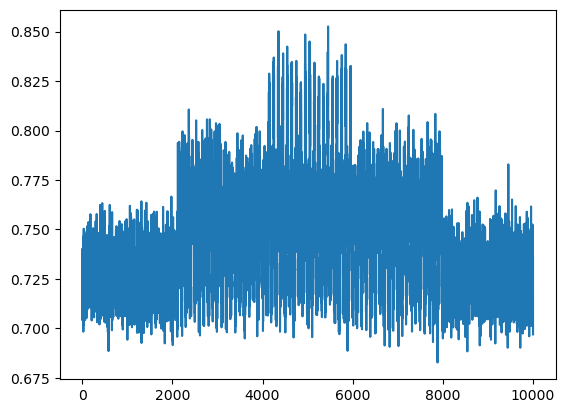

In [47]:
plt.plot(dwi_image_long[:,100])

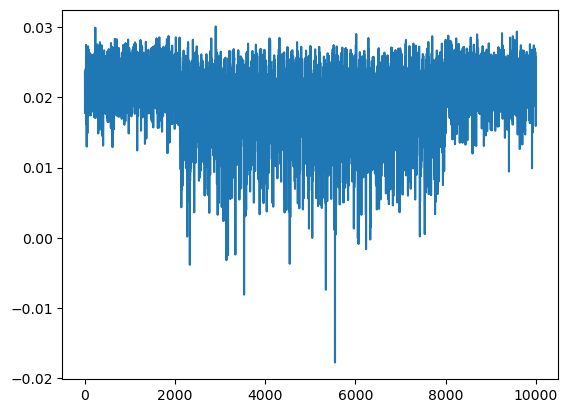

In [48]:
plt.plot(dwi_img_pred[:,100])

Plot parameter estimates and corresponding ground truths.

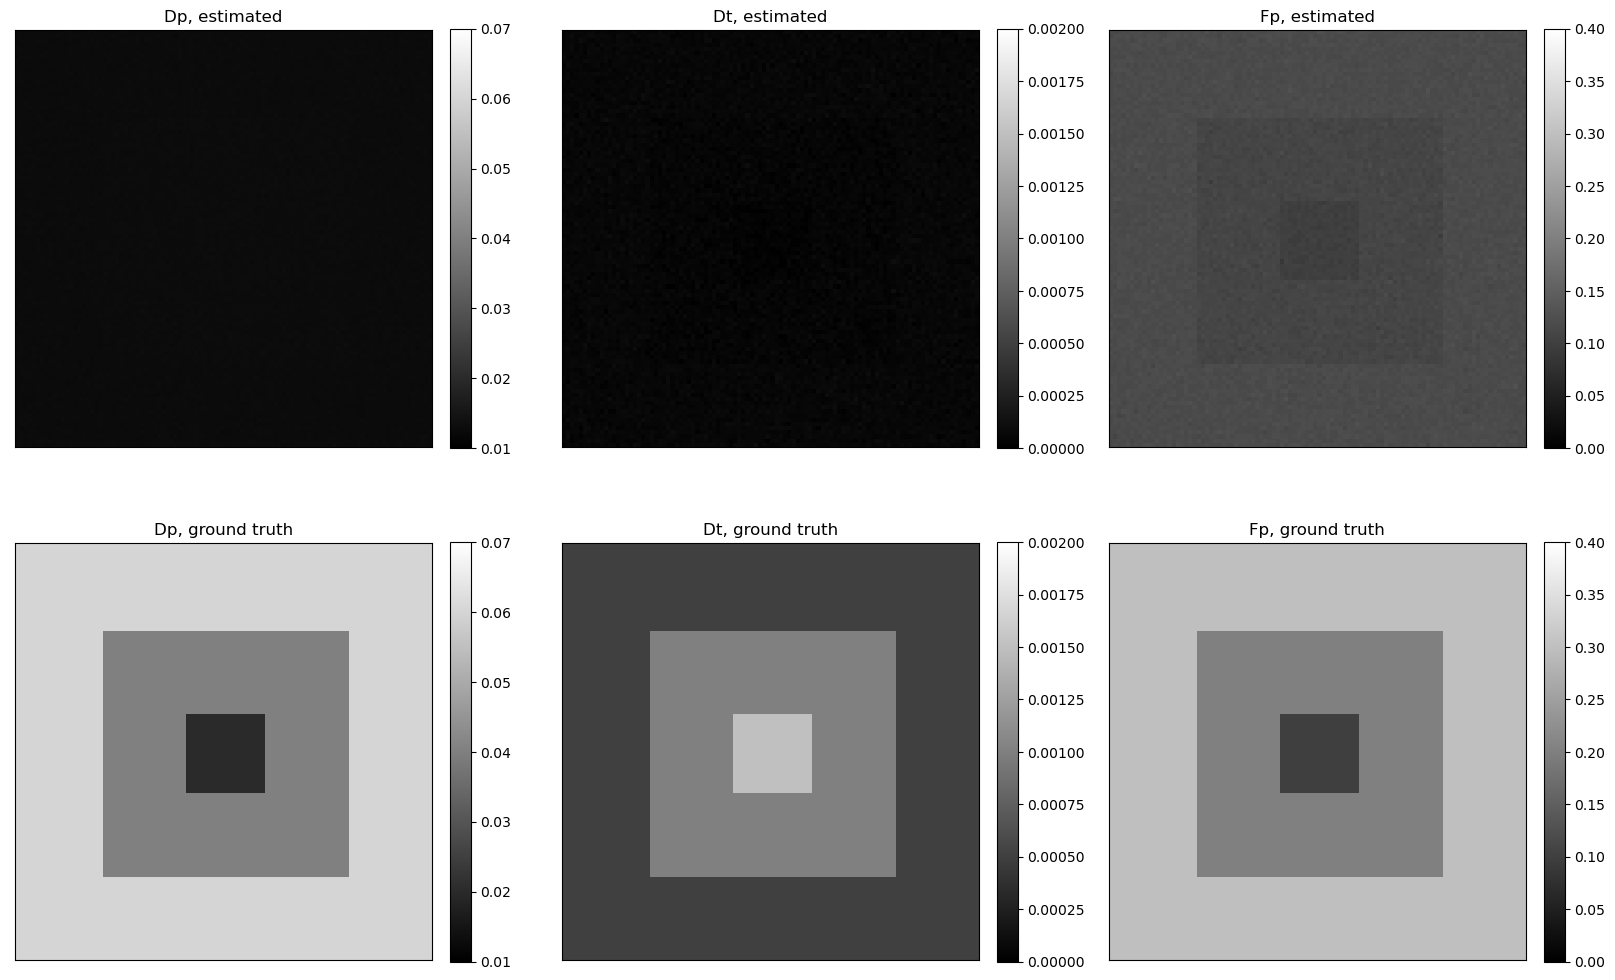

In [59]:
fig, ax = plt.subplots(2, 3, figsize=(20,20))

Dp_plot = ax[0,0].imshow(np.reshape(Dp, (sx, sy)), cmap='gray', clim=(0.01, 0.07))
ax[0,0].set_title('Dp, estimated')
ax[0,0].set_xticks([])
ax[0,0].set_yticks([])
fig.colorbar(Dp_plot, ax=ax[0,0], fraction=0.046, pad=0.04)

Dp_t_plot = ax[1,0].imshow(Dp_truth, cmap='gray', clim=(0.01, 0.07))
ax[1,0].set_title('Dp, ground truth')
ax[1,0].set_xticks([])
ax[1,0].set_yticks([])
fig.colorbar(Dp_t_plot, ax=ax[1,0], fraction=0.046, pad=0.04)

Dt_plot = ax[0,1].imshow(np.reshape(Dt, (sx, sy)), cmap='gray', clim=(0, 0.002))
ax[0,1].set_title('Dt, estimated')
ax[0,1].set_xticks([])
ax[0,1].set_yticks([])
fig.colorbar(Dt_plot, ax=ax[0,1],fraction=0.046, pad=0.04)

Dt_t_plot = ax[1,1].imshow(Dt_truth, cmap='gray', clim=(0, 0.002))
ax[1,1].set_title('Dt, ground truth')
ax[1,1].set_xticks([])
ax[1,1].set_yticks([])
fig.colorbar(Dt_t_plot, ax=ax[1,1], fraction=0.046, pad=0.04)

Fp_plot = ax[0,2].imshow(np.reshape(Fp, (sx, sy)), cmap='gray', clim=(0, 0.4))
ax[0,2].set_title('Fp, estimated')
ax[0,2].set_xticks([])
ax[0,2].set_yticks([])
fig.colorbar(Fp_plot, ax=ax[0,2],fraction=0.046, pad=0.04)

Fp_t_plot = ax[1,2].imshow(Fp_truth, cmap='gray', clim=(0, 0.4))
ax[1,2].set_title('Fp, ground truth')
ax[1,2].set_xticks([])
ax[1,2].set_yticks([])
fig.colorbar(Fp_t_plot, ax=ax[1,2], fraction=0.046, pad=0.04)

plt.subplots_adjust(hspace=-0.5)
plt.show()